In [40]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


In [3]:
results_file = 'write/endometrium-all-results.h5ad'

In [6]:
adata = sc.read_h5ad(
    'cache/endometrium_all.h5ad')

In [7]:
adata.var_names_make_unique()

## Preprocessing

normalizing counts per cell
    finished (0:00:14)


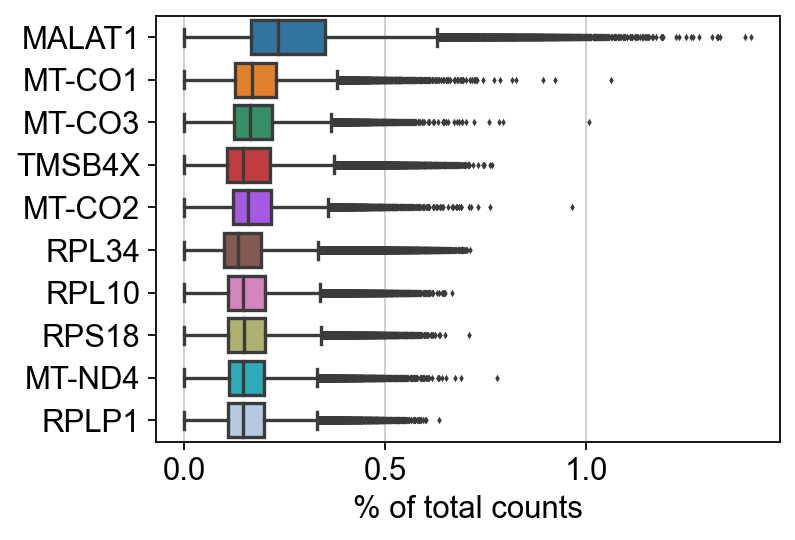

In [8]:
sc.pl.highest_expr_genes(adata, n_top=10)

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 355 genes that are detected in less than 3 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

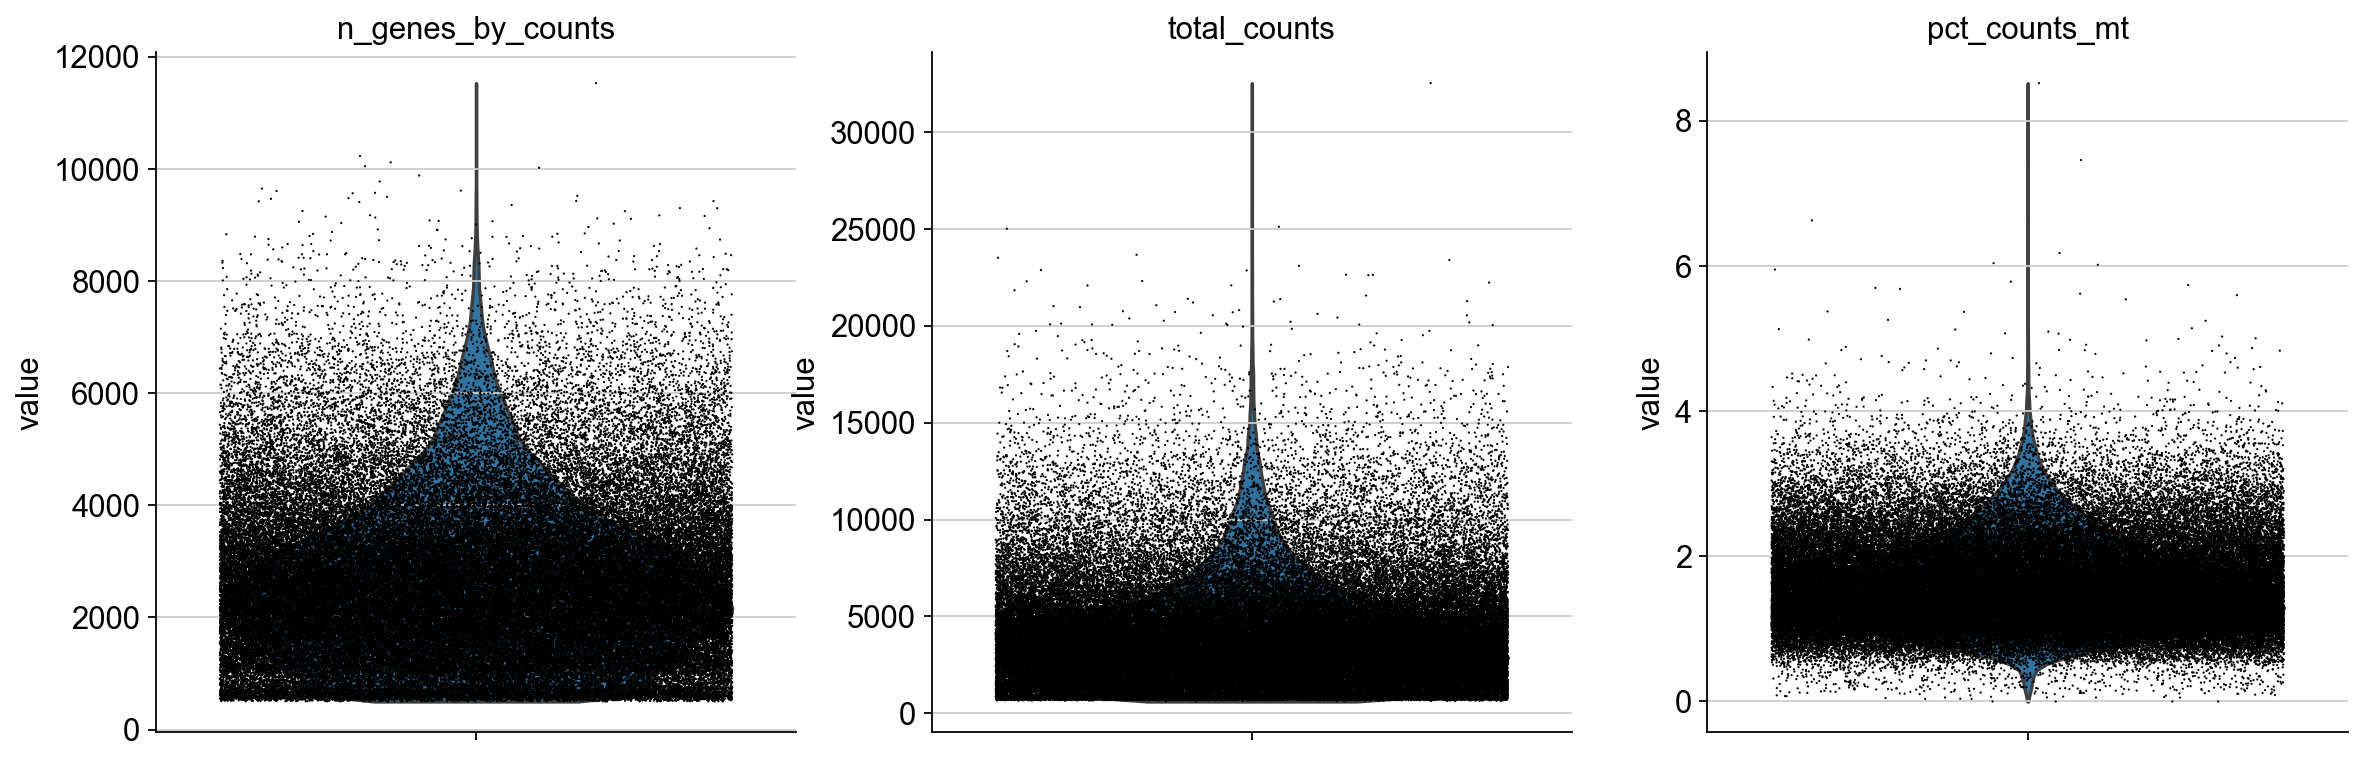

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

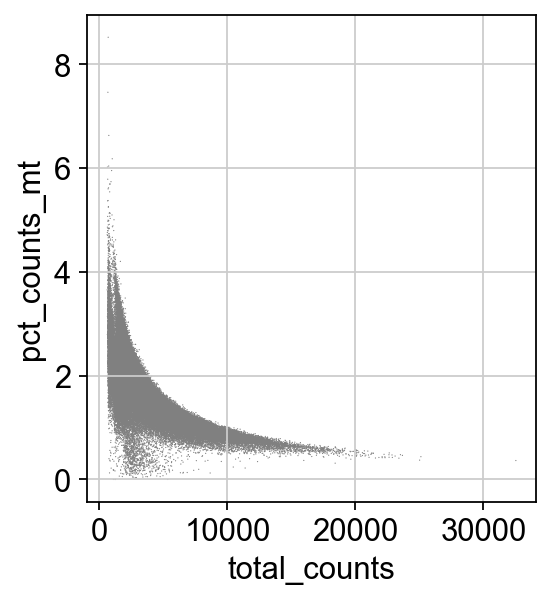

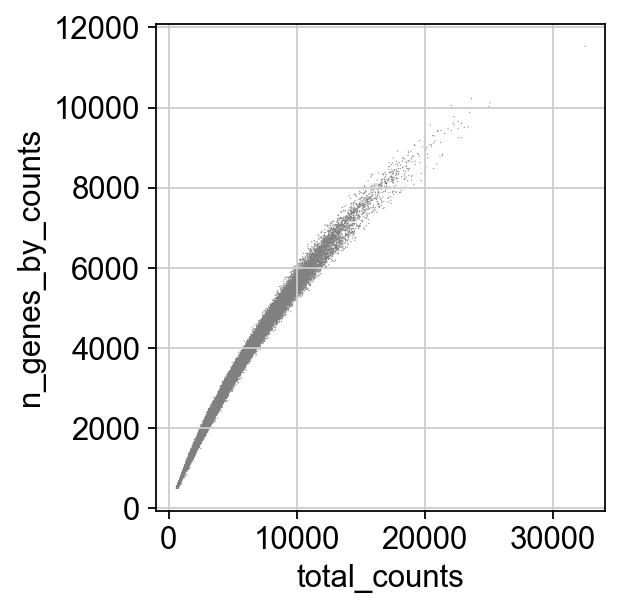

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 6500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)

/Users/franziskakoch/PycharmProjects/Organoids_sc_WS2122/venv/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:04)


In [15]:
sc.pp.log1p(adata)

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:27)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


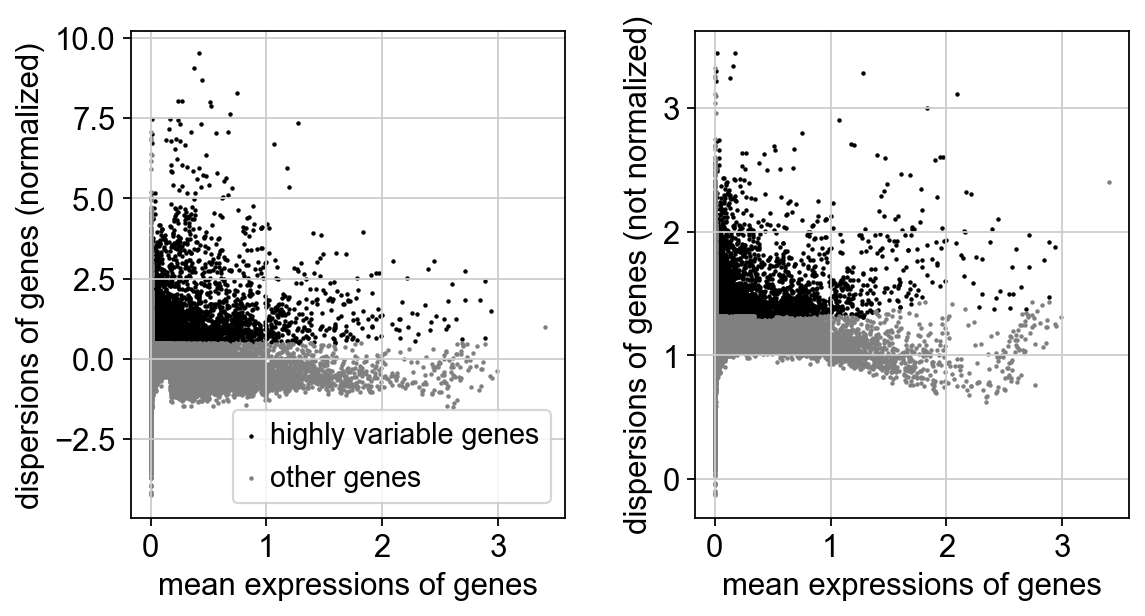

In [17]:
sc.pl.highly_variable_genes(adata)

In [18]:
adata.raw = adata

In [19]:
adata = adata[:, adata.var.highly_variable]

In [20]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:08:27)


In [29]:
sc.pp.scale(adata, max_value=20)

## PCA

In [31]:
sc.tl.pca(adata, n_comps=80, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=80
    finished (0:02:27)


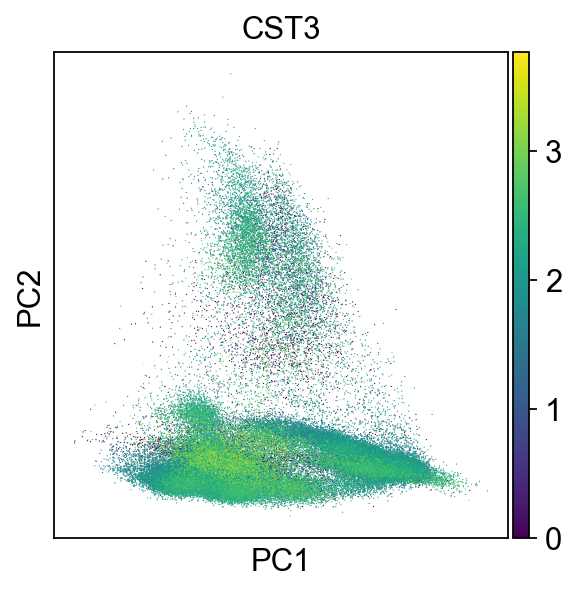

In [32]:
sc.pl.pca(adata, color='CST3')

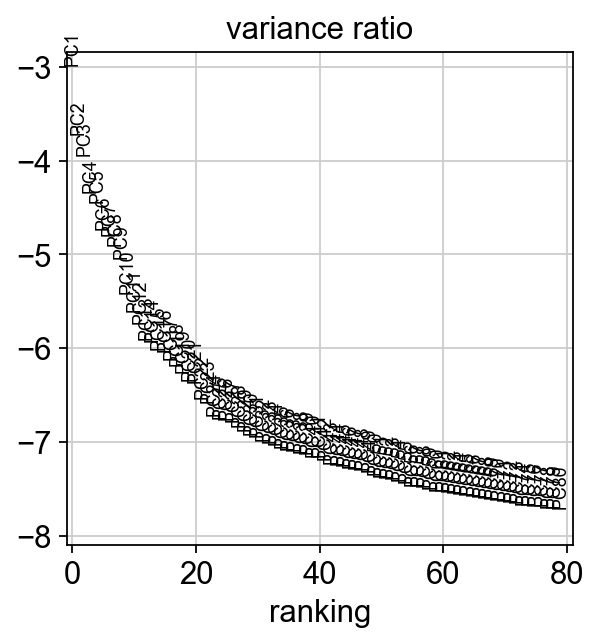

In [34]:
sc.pl.pca_variance_ratio(adata, n_pcs=80, log=True, )

In [35]:
adata

AnnData object with n_obs × n_vars = 98722 × 3349
    obs: 'SampleID', 'log2p1_count', 'percent_mito', 'n_genes', 'DonorID', 'BiopsyType', 'Location', 'Binary Stage', 'Stage', 'Broad cell type', 'Cell type', 'CellCycle Phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Binary Stage_colors', 'BinaryStage_colors', 'BiopsyType_colors', 'Broad cell type_colors', 'Cell type_colors', 'CellCycle Phase_colors', 'Day_colors', 'DonorID_colors', 'Location_colors', 'SampleID_colors', 'cosine_logXformedproj_bulkorg_colors', 'cosine_logXformedproj_bulkorg_hormnoinhib_colors', 'cosine_logXformedproj_bulkorg_hormnoinhib_res2_colors', 'cosine_logXformedproj_bulkorg_hormones_colors', 'cosine_logXformedproj_bulkorg_noinhib_colors', 'cosine_logXformedproj_bulkorg_strhormnoinhib_

## Computing the neighborhood graph

In [58]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=75)

computing neighbors
    using 'X_pca' with n_pcs = 75
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)


## Embedding the neighborhood graph

In [59]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:08)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:30)


In [60]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:46)


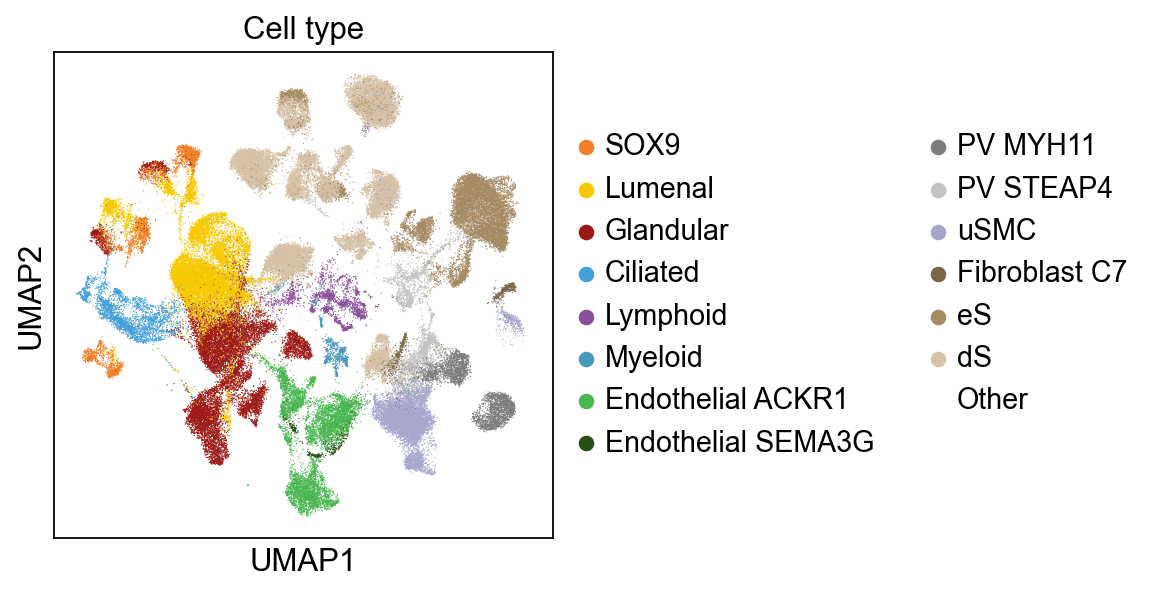

In [61]:
sc.pl.umap(adata, color=['Cell type'])

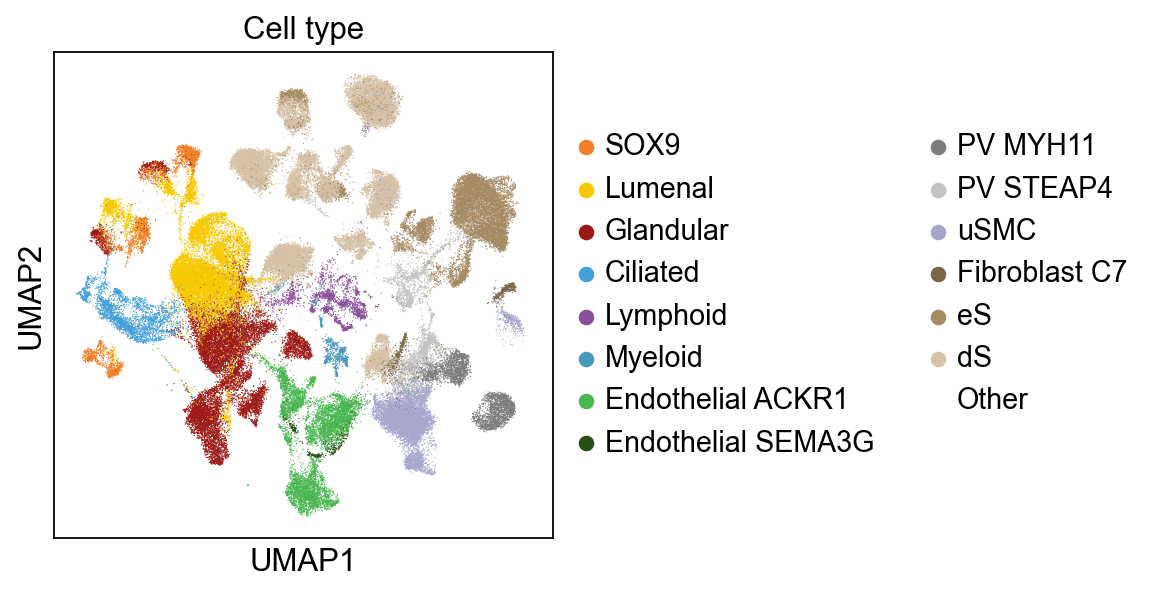

In [62]:
sc.pl.umap(adata, color=['Cell type'], use_raw=False)

In [63]:
adata.obs

,SampleID,log2p1_count,percent_mito,n_genes,DonorID,BiopsyType,Location,Binary Stage,Stage,Broad cell type,Cell type,CellCycle Phase,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
4861STDY7387181_AAACCTGAGGCATGGT,4861STDY7387181,13.951467,0.057320,3842,A13,Organ_Donor,endometrium_enriched,Proliferative,proliferative,Stromal,eS,S,3842,6091.234375,65.212105,1.070589,30
4861STDY7387181_AAACCTGAGGGCACTA,4861STDY7387181,13.776227,0.043838,3544,A13,Organ_Donor,endometrium_enriched,Proliferative,proliferative,Stromal,eS,G1,3544,5577.414551,60.933529,1.092505,0
4861STDY7387181_AAACCTGAGTGAAGTT,4861STDY7387181,12.894628,0.070791,2507,A13,Organ_Donor,endometrium_enriched,Proliferative,proliferative,Supporting,PV STEAP4,G1,2507,3600.496338,55.997944,1.555284,26
4861STDY7387181_AAACCTGAGTGGGCTA,4861STDY7387181,12.329235,0.071137,1928,A13,Organ_Donor,endometrium_enriched,Proliferative,proliferative,Stromal,dS,G1,1928,2623.698730,52.384651,1.996596,0
4861STDY7387181_AAACCTGCACCGAAAG,4861STDY7387181,12.171176,0.063977,1824,A13,Organ_Donor,endometrium_enriched,Proliferative,proliferative,Stromal,eS,G1,1824,2516.914551,48.167625,1.913757,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM4577315_TTTGGTTAGGATAATC,GSM4577315,15.003430,0.041133,6244,SAMN15049042,Superficial_Biopsy,endometrium_biopsy,Proliferative,proliferative,Epithelial,SOX9,G2M,6244,11652.254883,74.041283,0.635424,27
GSM4577315_TTTGGTTCACTACACA,GSM4577315,14.409987,0.025634,5045,SAMN15049042,Superficial_Biopsy,endometrium_biopsy,Proliferative,proliferative,Epithelial,SOX9,G1,5045,8743.480469,58.970543,0.674452,27
GSM4577315_TTTGGTTGTCCGACGT,GSM4577315,13.338180,0.079575,2911,SAMN15049042,Superficial_Biopsy,endometrium_biopsy,Proliferative,proliferative,Epithelial,SOX9,G1,2911,4476.934570,64.697418,1.445128,27
GSM4577315_TTTGTTGGTTCGGCCA,GSM4577315,13.996120,0.059918,4592,SAMN15049042,Superficial_Biopsy,endometrium_biopsy,Proliferative,proliferative,Epithelial,SOX9,G2M,4592,7388.960938,70.985031,0.960690,27
